In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import time
import datetime
import numpy as np
import pickle as pkl
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from graspy.simulations import er_np, sbm
from graspy.embed import AdjacencySpectralEmbed
from graspy.inference import LatentDistributionTest

In [2]:
def fit_avantis_plug_in(X):
    '''
    estimates the variance using the plug-in estimator.
    rdpg survey, equation 10.
    
    assume X in M_{n,d}
    '''
    n = len(X)
    delta = 1 / (n) * (X.T @ X)
    delta_inverse = np.linalg.inv(delta)
    
    def avantis_plug_in(x):
        '''assume x in M_{n,d}'''
        if x.ndim < 2:
            undo_dimensions = True
            x = x.reshape(1, -1)
        else:
            undo_dimensions = False
        middle_term = np.sum(x @ X.T - (x @ X.T) ** 2, axis=1) / (n)
        middle_term = np.outer(middle_term, delta)
        if undo_dimensions:
            middle_term = middle_term.reshape(delta.shape)
        else:
            middle_term = middle_term.reshape(-1, *delta.shape)
        return delta_inverse @ middle_term @ delta_inverse
        
    return avantis_plug_in

In [3]:
def sample_noisy_points(X, Y):
    n = len(X)
    m = len(Y)
    two_samples = np.concatenate([X, Y], axis=0)
    get_sigma = fit_avantis_plug_in(two_samples)
    sigma_X = get_sigma(X) / m
    sigma_Y = get_sigma(Y) / n
    X_sampled = np.zeros(X.shape)
    for i in range(n):
        X_sampled[i,:] = X[i, :] + stats.multivariate_normal.rvs(cov=sigma_X[i])
    Y_sampled = np.zeros(Y.shape)
    for i in range(m):
        Y_sampled[i,:] = Y[i, :] + stats.multivariate_normal.rvs(cov=sigma_Y[i])
    return X_sampled, Y_sampled

In [4]:
def mc_iter(n, m, p, q, tilde, i=1):
    X_graph = er_np(n, p)
    ase = AdjacencySpectralEmbed(n_components=1)
    X = ase.fit_transform(X_graph)

    Y_graph = er_np(m, q)
    ase = AdjacencySpectralEmbed(n_components=1)
    Y = ase.fit_transform(Y_graph)

    if tilde:
        X_new, Y_new = sample_noisy_points(X, Y)
    else:
        X_new, Y_new = X, Y

    ldt = LatentDistributionTest()
    pval = ldt.fit(X_new, Y_new, pass_graph=False) #, median_heuristic=False)
    return pval

def mc_iter_wrapper(i, n, m, p, q, tilde):
    np.random.seed(int(time.time() * i) % 100000000)
    return i, mc_iter(n, m, p, q, tilde, i)

def monte_carlo(n, m, p, q, tilde=False, mc_iters=200):
    pool = Pool(cpu_count() - 2)
    pvals = np.zeros(mc_iters)
    
    pbar = tqdm(total=mc_iters)
    def update(tup):
        i, ans = tup
        # note: input comes from async `wrapMyFunc`
        pvals[i] = ans  # put answer into correct index of result list
        pbar.update()
    
    results = [None] * mc_iters
    for i in range(mc_iters):
        results[i] = pool.apply_async(mc_iter_wrapper,
                         args = (i, n, m, p, q, tilde),
                         callback=update)
    for r in results:
        r.get()
        
    pool.close()
    pool.join()
    pbar.close()

    return np.array(pvals) < 0.05

In [8]:
mc_iters = 500
ns = [25, 50, 100, 200, 600, 800]
cs = [1, 2, 5, 6+1, 10, 15, 20]
p=0.8

In [ ]:
data = {}
for c in cs:
    print(str(datetime.datetime.now()) + ' current c: {}'.format(c))
    print(str(datetime.datetime.now()) + ' unmodified non-par')
    tests_size_er_xhat = [monte_carlo(n=i, m=c*i, p=p*p, q=p*p,
                                      mc_iters=mc_iters, tilde=False)
                          for i in ns]
    size_er_xhat = np.array([np.sum(i)/mc_iters for i in tests_size_er_xhat])
    print(str(datetime.datetime.now()) + ' modified non-par')
    tests_size_er_xtilde = [monte_carlo(n=i, m=c*i, p=p*p, q=p*p,
                                        mc_iters=mc_iters, tilde=True)
                            for i in ns]
    size_er_xtilde = np.array([np.sum(i)/mc_iters for i in tests_size_er_xtilde])
    data[c] = (size_er_xhat, size_er_xtilde)
#     pkl.dump(data, open( "graphs_size.pkl", "wb" ))

2019-11-08 18:12:40.755884 current c: 1
2019-11-08 18:12:40.756334 unmodified non-par


100%|██████████| 500/500 [05:56<00:00,  3.06it/s] 

2019-11-08 18:22:58.326801 modified non-par



100%|██████████| 500/500 [05:58<00:00,  9.02it/s] 

2019-11-08 18:33:16.403749 current c: 2
2019-11-08 18:33:16.403891 unmodified non-par



 59%|█████▉    | 295/500 [08:47<12:53,  3.77s/it]  

In [6]:
data = pkl.load(open("graphs_size.pkl", "rb" ))

In [15]:
data.keys()

dict_keys([1, 2, 5])

KeyError: 7

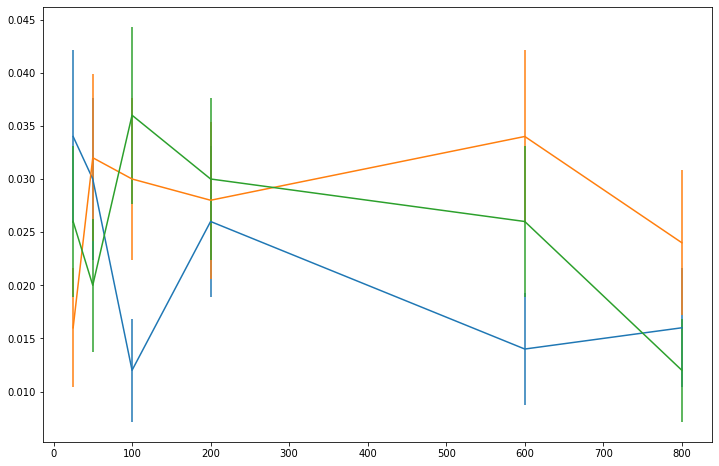

In [11]:
fig01, ax01 = plt.subplots(1, 1, figsize=(12,8))
for c in cs:
    ax01.errorbar(x = ns, y=data[c][1],
                  yerr=np.sqrt(data[c][1]*(1-data[c][1])/mc_iters),
                  label='xtilde (modified), c={}'.format(c))
ax01.plot(ns, np.ones(len(ns)) * 0.05, 'k--', label='0.05')
ax01.set_title("size of the modified nonparametric test for various n \n"+
               "Graphs: ER(n, p), N(m, p); m=cn")
ax01.set_xlabel("n")
ax01.set_ylabel("size of the test")
ax01.set_ylim([-0.05, 1.05])
ax01.set_xticks(ns)
ax01.legend(bbox_to_anchor=(1.04,1), loc="upper left")

KeyError: 7

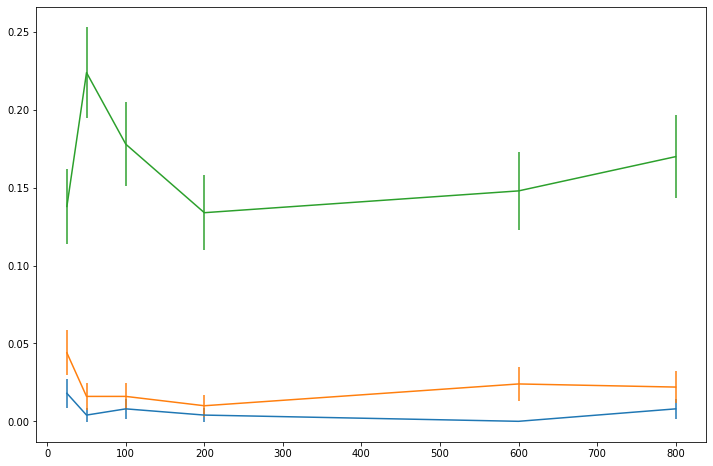

In [10]:
fig02, ax02 = plt.subplots(1, 1, figsize=(12,8))
for c in cs:
    ax02.errorbar(x = ns, y=data[c][0],
                  yerr=np.sqrt(data[c][0]*(1-data[c][0])/200),
                  label='xhat (unmodified), c={}'.format(c))
ax02.plot(ns, np.ones(len(ns)) * 0.05, 'k--', label='0.05')
ax02.set_title("size of the unmodified nonparametric test for various n \n"+
               "Graphs: ER(n, p), N(m, p); m=cn")
ax02.set_xlabel("n")
ax02.set_ylabel("size of the test")
ax02.set_ylim([-0.05, 1.05])
ax02.set_xticks(ns)
ax02.legend(bbox_to_anchor=(1.04,1), loc="upper left");